In [1]:
import pandas as pd
import numpy as np
import random
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from modules import utils, constants
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc

In [2]:
SEED = constants.SEED
random.seed(SEED)
np.random.seed(SEED)

#### Reading and splitting the dataset

In [4]:
#train_df = pd.read_csv('../data/train_set_basic.csv')
train_df = pd.read_csv('../data/18_jan/train_set_basic.csv')
train_df = train_df.fillna(-1)
X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]
X_train.head()
#train_df.label.value_counts()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,acute_pericarditis,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,1,0,0,0,0,0,1,0,...,0,1,1,0,1,0,1,0,0,0


In [5]:
test_df = pd.read_csv('../data/18_jan/test_set_basic.csv')
X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]
X_test.head()
#test_df.label.value_counts()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,acute_pericarditis,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,1,0,0,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1,1,0,0,0,1,0,0,1,0,...,0,0,1,1,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#X_train, y_train = np.array(X_train), np.array(y_train)
#X_test, y_test = np.array(X_test), np.array(y_test)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt = DecisionTreeClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
test_df_dt = pd.DataFrame()
test_df_dt['y_actual'] = y_test
test_df_dt['y_pred'] = y_pred_dt
test_df_dt.isna().sum()

y_actual    0
y_pred      0
dtype: int64

In [8]:
acc_dt, prec_dt, recall_dt, f1_dt = utils.test_binary(test_df_dt['y_actual'], test_df_dt['y_pred'])
acc_dt, prec_dt, recall_dt, f1_dt

(99.62857142857143, 99.81996953330564, 99.4618462812198, 99.64058612109483)

In [9]:
acc_dt2, f1_dt2, roc_auc_dt2 = utils.test(test_df_dt['y_actual'], test_df_dt['y_pred'])
acc_dt2, f1_dt2, roc_auc_dt2

(99.62857142857143, 99.62815590417733, 99.63466962365447)

In [10]:
#from sklearn import tree
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(dt, 
#                   feature_names=X_train.columns,  
#                   class_names=['no lupus', 'lupus'],
#                   filled=True)
#fig.savefig('../images/dt_basic.png')

In [11]:
import graphviz
dot_data = export_graphviz(dt, out_file=None, 
                                feature_names= X_train.columns,  
                                class_names=['no lupus', 'lupus'],
                                filled=True)


graph = graphviz.Source(dot_data, format='png') 
#graph
# Convert to image using dot -Tpng images/dt_basic.dot -o images/dt_basic.png 
# Make sure to have graphviz installed (windows executable file like normal software)

##### Feature importance

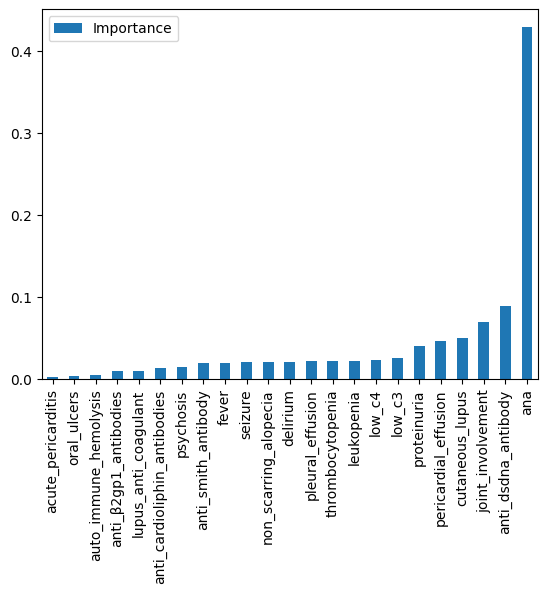

In [12]:
utils.compute_feature_importance(dt, X_train)

##### SHAP

In [13]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test)
len(shap_values)

2

In [14]:
shap_values[0].shape

(14000, 23)

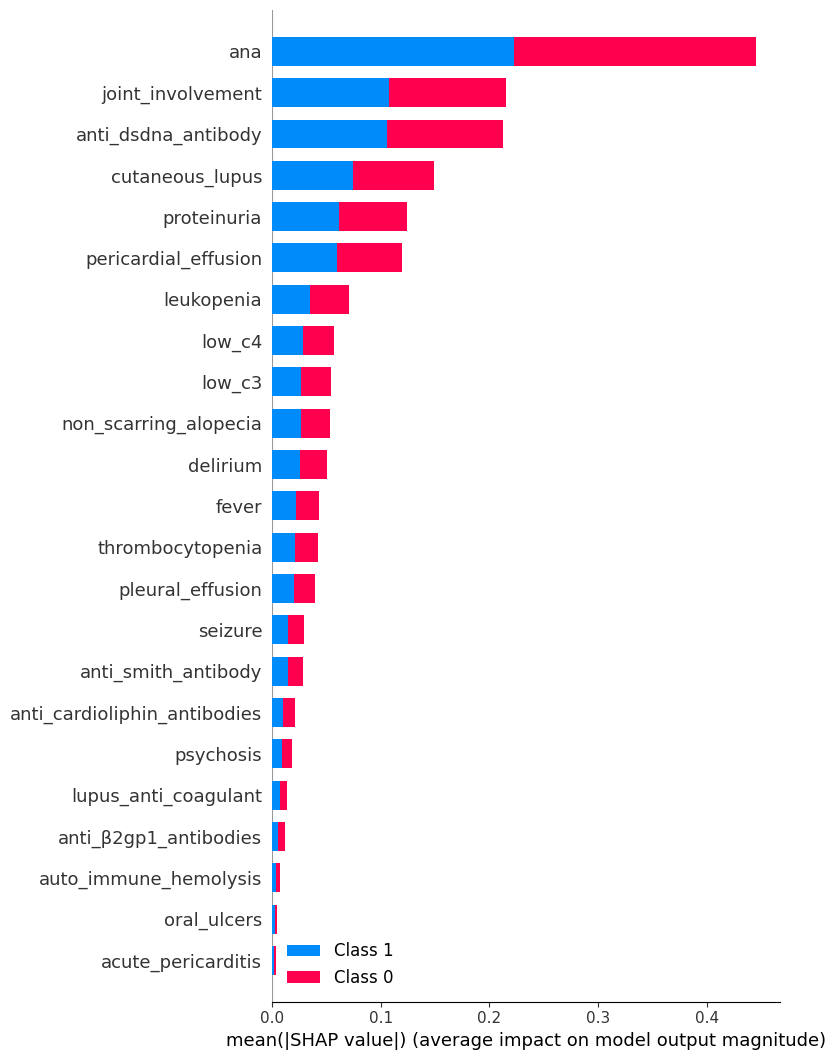

In [15]:
shap.summary_plot(shap_values, X_test, max_display=30)

#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
test_df_rf = pd.DataFrame()
test_df_rf['y_actual'] = y_test
test_df_rf['y_pred'] = y_pred_rf
test_df_rf.isna().sum()

y_actual    0
y_pred      0
dtype: int64

In [18]:
acc_rf, prec_rf, recall_rf, f1_rf = utils.test_binary(test_df_rf['y_actual'], test_df_rf['y_pred'])
acc_rf, prec_rf, recall_rf, f1_rf 

(99.57142857142857, 99.90279127898903, 99.26866289499104, 99.58471760797343)

In [19]:
acc_rf2, f1_rf2, roc_auc_rf2 = utils.test(test_df_rf['y_actual'], test_df_rf['y_pred'])
acc_rf2, f1_rf2, roc_auc_rf2

(99.57142857142857, 99.57098926443535, 99.58250263067336)

#### XGBoost

In [20]:
import xgboost as xgb
xg = xgb.XGBClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
test_df_xg = pd.DataFrame()
test_df_xg['y_actual'] = y_test
test_df_xg['y_pred'] = y_pred_xg
test_df_xg.isna().sum()

y_actual    0
y_pred      0
dtype: int64

In [21]:
acc_xg, prec_xg, recall_xg, f1_xg = utils.test_binary(test_df_xg['y_actual'], test_df_xg['y_pred'])
acc_xg, prec_xg, recall_xg, f1_xg

(99.86428571428571, 99.9309201436861, 99.80681661377122, 99.86882982395582)

In [22]:
acc_xg2, f1_xg2, roc_auc_xg2 = utils.test(test_df_xg['y_actual'], test_df_xg['y_pred'])
acc_xg2, f1_xg2, roc_auc_xg2

(99.86428571428571, 99.86412264412738, 99.8663877234412)